In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Sample text about Muhammad Ali
text = """Muhammad Ali was born Cassius Marcellus Clay Jr. in Louisville, Kentucky in 1942. 
He began training as a boxer at the age of 12 and quickly showed remarkable talent.
Ali won an Olympic gold medal in 1960 and went on to become world heavyweight champion in 1964 when he defeated Sonny Liston.
Shortly after winning the title, he converted to Islam and changed his name to Muhammad Ali.
Ali was known for his extraordinary speed and reflexes, his ability to "float like a butterfly, sting like a bee."
He was not only a great athlete but also a cultural icon who stood up for his beliefs.
Ali refused to be drafted into the military during the Vietnam War, citing his religious beliefs and opposition to the war.
As a result, he was stripped of his title and banned from boxing for nearly four years.
Ali returned to boxing in 1970 and regained the heavyweight title in 1974 by defeating George Foreman in the famous "Rumble in the Jungle."
Muhammad Ali remains one of the most celebrated and influential sports figures of all time."""

print(f"Total characters in the text: {len(text)}")

Total characters in the text: 1031


In [3]:
# Create a mapping from characters to integers and back
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Total unique characters: {len(chars)}")
print("Characters:", ''.join(chars))

# Convert the text to numbers
data = [char_to_idx[ch] for ch in text]

Total unique characters: 51
Characters: 
 ",.0124679ACFGHIJKLMORSVWabcdefghiklmnopqrstuvwxy


In [4]:
# Define sequence length for training
seq_length = 25
num_sequences = len(text) - seq_length

# Prepare input and target sequences
X = []
y = []

for i in range(num_sequences):
    # Input is a sequence of characters
    input_seq = data[i:i+seq_length]
    # Target is the next character after each sequence
    target = data[i+seq_length]
    
    X.append(input_seq)
    y.append(target)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

print(f"X shape: {X_tensor.shape}, y shape: {y_tensor.shape}")

X shape: torch.Size([1006, 25]), y shape: torch.Size([1006])


In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        # Embedding layer to convert character indices to embeddings
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # RNN layer
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # Convert indices to embeddings
        x = self.embedding(x)
        
        # Pass through RNN
        out, hidden = self.rnn(x, hidden)
        
        # We only care about the last output for prediction
        out = self.fc(out[:, -1, :])
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.rnn.hidden_size)

# Model parameters
input_size = len(chars)  # Number of unique characters
hidden_size = 128
output_size = len(chars)  # Number of possible output characters

# Initialize the model
model = SimpleRNN(input_size, hidden_size, output_size)
print(model)

SimpleRNN(
  (embedding): Embedding(51, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=51, bias=True)
)


Epoch [10/50], Loss: 3.4602
Epoch [20/50], Loss: 2.9821
Epoch [30/50], Loss: 2.8797
Epoch [40/50], Loss: 2.3410
Epoch [50/50], Loss: 2.5607


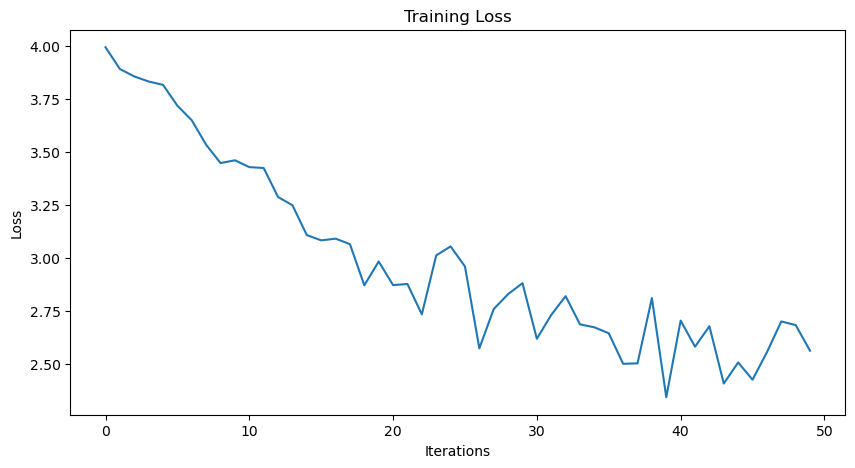

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
batch_size = 64
num_epochs = 50
clip_value = 5.0  # To prevent exploding gradients

# Lists to store losses for plotting
all_losses = []

# Training loop
for epoch in range(num_epochs):
    # Initialize hidden state
    hidden = model.init_hidden(batch_size)
    
    # Create random batches
    indices = torch.randperm(len(X_tensor))[:batch_size]
    inputs = X_tensor[indices]
    targets = y_tensor[indices]
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs, hidden = model(inputs, hidden.detach())
    
    # Calculate loss
    loss = criterion(outputs, targets)
    
    # Backward pass
    loss.backward()
    
    # Clip gradients to prevent explosion
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    
    # Update weights
    optimizer.step()
    
    # Store loss
    all_losses.append(loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [7]:
def generate_text(model, start_text, length=200):
    # Set model to evaluation mode
    model.eval()
    
    # Convert start text to indices
    chars_indices = [char_to_idx[ch] for ch in start_text]
    
    # Initialize hidden state
    hidden = model.init_hidden(1)
    
    # Generate one character at a time
    with torch.no_grad():
        for _ in range(length):
            # Prepare input tensor (adding batch dimension)
            x = torch.tensor([chars_indices[-seq_length:]], dtype=torch.long)
            
            # Forward pass
            output, hidden = model(x, hidden)
            
            # Sample from the output distribution
            # Simple sampling: pick the most likely character
            _, top_idx = output.topk(1)
            predicted_idx = top_idx.item()
            
            # Add predicted character to the sequence
            chars_indices.append(predicted_idx)
    
    # Convert indices back to characters
    generated_text = start_text + ''.join([idx_to_char[idx] for idx in chars_indices[len(start_text):]])
    
    return generated_text

# Generate text using our model
seed_text = "Muhammad Ali "
generated = generate_text(model, seed_text)
print(generated)

Muhammad Ali to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to


In [ ]:
def ask_question(question, text):
    """
    Function to answer simple questions based on the provided text.
    Very basic implementation using string matching.
    """
    question = question.lower()
    text = text.lower()
    
    # Simple keyword mapping
    if "born" in question or "birth" in question:
        # Find information about birth
        sentences = text.split('.')
        for sentence in sentences:
            if "born" in sentence:
                return f"Answer: {sentence.strip()}"
    
    elif "champion" in question or "title" in question:
        # Find information about championship
        sentences = text.split('.')
        for sentence in sentences:
            if "champion" in sentence:
                return f"Answer: {sentence.strip()}"
    
    elif "name change" in question or "changed his name" in question:
        # Find information about name change
        sentences = text.split('.')
        for sentence in sentences:
            if "changed his name" in sentence:
                return f"Answer: {sentence.strip()}"
    
    # Add more question patterns as needed
    
    return "I don't have specific information to answer that question based on the text."

# Test the function with a simple question
question = "When was Muhammad Ali born in ?"
answer = ask_question(question, text)
print(answer)

Answer: muhammad ali was born cassius marcellus clay jr


: 